In [1]:
#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

In [2]:
#hide
!pip install kaggle
from fastbook import *
from zipfile import ZipFile
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
# In this exercise, we will be expanding on the collab exercise by further experimenting with
# different types of tabular data. This brings forth the topic of 'categorical embeddings'
# The idea of categorical embeddings is that we will be working with two general types of data:
    # Continuous Data, such as age, and 
    # Discrete Data, such as movie ID's and sex, where addition and multiplication have no meaning
    
# The number of discrete data a category has is called it's cardinality, so sex would have a cardinality of 2

# The approach we will see here is very useful for datasets with lots of high cardinality features
# and is reffered to as entity embedding, and is guided by the principle of mapping similar values
# close to one another and thus, reveals intrinsic properties of the categorical variable

# In other words: entity embedding defines a distance measure for categorical variables and can be used 
# for visualizing categorical data and for data clustering.

# The Rossman sales competition that ran on kaggle, which consists of a 
# wide range of data across different stores in Germany and the goal was to help predict sales on days
# to help the stores manage stock and inventory

# We will be mirroring the strategy of one of the gold medalists, who used a state of the art
# deep learning tabular model focused on entity embedding, but with the Blue Book for bulldozers dataset.


# At first we will explore the different methods used to perform such predictions:h
    # 1. Ensembles of decision trees (i.e., random forests and gradient boosting machines), mainly for 
    # structured data (such as you might find in a database table at most companies)
    
    # 2. Multilayered neural networks learned with SGD (i.e., shallow and/or deep learning), mainly for 
    # unstructured data (such as audio, images, and natural language) 
    
# For our decision tree ensembles we will be using a scikit-learn (sklearn) which is a popular library
# for creating machine learning models using approaches that are not covered by deep learning
# We will also be using Pandas and NumPy. We will not be using Pytorch and fastai for that portion as those
# libraries are designed to take the load of matrix multiplication and derivatives, which are tailored
# to deep learning

In [4]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [5]:
path = URLs.path('bluebook')
path

Path('/home/slabban/.fastai/archive/bluebook')

In [6]:
#hide
Path.BASE_PATH = path

In [7]:
# The path_extract fucntion from the book did not work, so I used the ZipFile Library to get the same result

if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli('bluebook-for-bulldozers', path=path)
    #ZipFile.extractall(path=path/'bluebook-for-bulldozers.zip')
    with ZipFile(path/'bluebook-for-bulldozers.zip', 'r') as zip:
    # printing all the contents of the zip file
        zip.printdir()

        # extracting all the files
        print('Extracting all the files now...')
        zip.extractall(path)
        print('Done!')

path.ls(file_type='text')

(#7) [Path('Valid.csv'),Path('random_forest_benchmark_test.csv'),Path('TrainAndValid.csv'),Path('Test.csv'),Path('Machine_Appendix.csv'),Path('median_benchmark.csv'),Path('ValidSolution.csv')]

In [8]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [9]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [10]:
# As a first step, we will handle the ordinal columns (Columns that contain string that have a natural ordering)

df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [11]:
# We can tell Pandas about a suitable ordering of these levels
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [12]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [13]:
# Kaggle tells us that the dependent variable (Variable to be predicted) and that we are to use the 
# root mean squared log error (RMSLE) as our metric

dep_var = 'SalePrice'

In [14]:
df[dep_var] = np.log(df[dep_var])

In [15]:
# Decision Tree Ensembles are based off of a binary tree, where we will work down the tree based on the
# answers of yes or no questions until we arrive at our leaf nodes. 

# The basic steps of how to organize this tree based on our given category is straight forward:

# 1. Loop through each column of the dataset in turn
# 2. For each column, loop through each possible level of the column
# 3. Try splitting the data into two groups, based on whether they are greater than or less than that value 
#     (or if it is a categorical variable, based on whether they are equal to or not equal to that level of 
#     that categorical variable).
# 4. Find the average sale price for each of these two groups and compare that to the actual sale price
# 5. After looping through all the columns, choose the split point that gave the best predictions
# 6. With our two different groups, treat each of these as seperate datasets and return to step 1 to find
#     the next best split
# 7. Continue this process recursively until we have reached a stopping criterion for each group
#     ex. stop splitting the group once it only has 20 items in it
    
# sklearn has such implementations built in, and we well see how to leverage it after we do some data preperation.

In [16]:
# Our next order of data manipulation is an example of an important concpet called feature engnieering
# We want to essentially breakdown our data information further in order to give our model the
# ability interpret different factors that relate to the date, such as end of the year or month, or 
# holidays etc.

df['saledate']

0         11/16/2006 0:00
1          3/26/2004 0:00
2          2/26/2004 0:00
3          5/19/2011 0:00
4          7/23/2009 0:00
               ...       
412693      3/7/2012 0:00
412694     1/28/2012 0:00
412695     1/28/2012 0:00
412696      3/7/2012 0:00
412697     1/28/2012 0:00
Name: saledate, Length: 412698, dtype: object

In [17]:
# fastai comes with a function that allows us to do this called 'add_datepart' all we have to do is
# pass in the column that contains the dates

df = add_datepart(df, 'saledate')

In [18]:
# We should do this with our test data as well

df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [19]:
# Lets vizualise our new date information

' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [20]:
# Our next order of operation is to handle strings and missing data. The 'TabularPandas' is a useful
# wrapper of the Pandas Dataframe that provides a few convenince features. Namely, we will be using
# 'TabulaProc's, 'Categorify' and 'FillMissing' to do this, 'Categorify' will essentially enumerate
# our categories and 'FillMissing' will fill our empty slots with the median of the column and create a new
# Boolean Column that is set to True for all filled values

procs = [Categorify, FillMissing]

In [21]:
# TabularPandas also enable us to split the training and validation set, and since this is a time series
# related challenge where the Kaggle test set will comprise of data that is in the future, we will 
# want to split our data in a fashion that our validation set will have values that correspond to dates after
# our training set. For  this data we choose our training set to contain data that is before November 2011
# and our validation set to contain values that are after that date

# To do this we use np.where, a useful function that returns (as the first element of a tuple) 
# the indices of all True values:

cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [22]:
# TabularPandas need to be told which columns are continuous and which are categorical
# We can do this with its 'cont_cat_split' function, where we feed in our dataframe and saleprice

cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [23]:
# We execute the train and valid split in the assembled function

to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [24]:
# TabularPandas behave a lot like Datasets in that it attributes the split to train and valid

len(to.train),len(to.valid)

(404710, 7988)

In [25]:
#hide_output
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [26]:
# We can vizualise the data as such

#hide_input
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


In [27]:
# Here we can see the underlying numeric assignments that TabularPandas has done for us

#hide_output
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


In [28]:
#hide_input
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [29]:
# since categorical values are assigned sequentially by assigning each unique category with a number
# there is no particular meaning to the order of the numbers, with the exception of columns that we ordered
# in Pandas, in our case it was the ProductSize column

to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [30]:
# Probably should have learn this earlier, but fastai provides a save method that allows us to 
# save and load the cells we had run until this point

# to load this data we input: to = (path/'to.pkl').load()

save_pickle(path/'to.pkl',to)

In [31]:
#hide
to = load_pickle(path/'to.pkl')

#to = (path/'to.pkl').load()

In [32]:
# Lets format our variables visually to be used in the decision tree

xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [33]:
# Using sklearn, we can run the following lines tio create our Decision Tree Model

m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

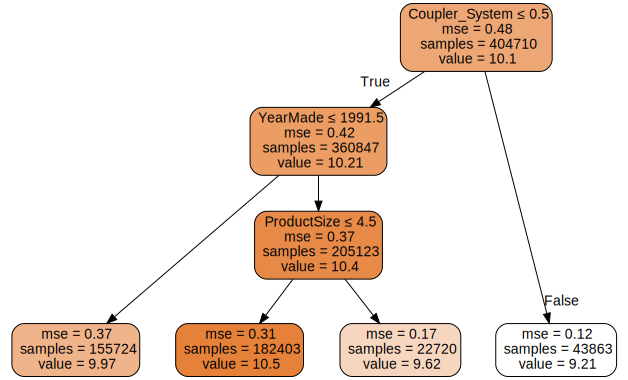

In [34]:
# We can display the tree with the following line

# Using the steps described in line 16, sklearn has done the heavy lifting for us and found the best 
# Binary tree that will result in an accurate price prediction based on our desried output of 4 leaf nodes

draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

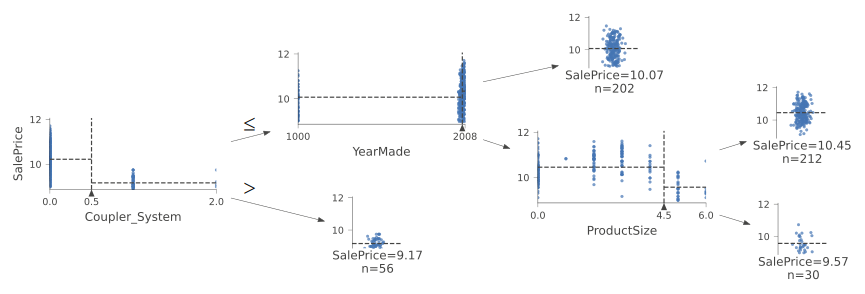

In [35]:
# Another cool way to visualize this is using the dtreeviz library, where our threshold decision is indicated
# by the black triangle marker that lies on the x-axis

# though it looks like our year made graph is not quite informative do to an improperly fit x-axis

samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [36]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

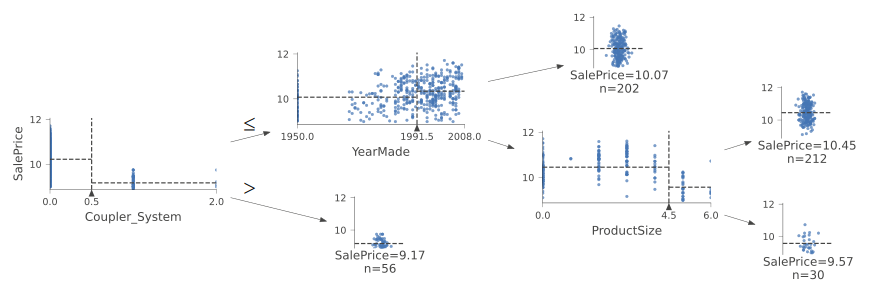

In [37]:
# Now we can get a little more insight into the yearmade portion of the tree

m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [38]:
# Lets try to re-create our model, this time we will remove our set limit for the max leaf nodes

m = DecisionTreeRegressor()
m.fit(xs, y);

In [39]:
# Lets create a utility function to test our root mean squared error, since that is the metric that
# was used in this kaggle competition

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [40]:
# Based on the training set we have a perfectly trained model

m_rmse(m, xs, y)

0.0

In [41]:
# Having a look at the validation set, we can infer that there is a clear case of overfitting lets see why..

m_rmse(m, valid_xs, valid_y)

0.334935

In [42]:
# Analyzing the model, we can see there are almost as many leaf nodes as there are data items, this comes from
# sklearn's powerful abiltiy to maximize the amount of leaf nodes, which results in overfitting

# Essentially our model is memorizing this training set

m.get_n_leaves(), len(xs)

(324560, 404710)

In [43]:
# We can counter this by setting the minimum samples per leaf node as such:

# Our training set has gotten worse, but our validation has improved, i.e we can generalize better

m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248593, 0.323339)

In [44]:
# As expected our, leaf count has decreased

m.get_n_leaves()

12397

In [45]:
# Random Forests

In [46]:
# We will look into an approach called Bagging Predictors and is quite simple, but powerful:

    # 1. Randomly choose a a subset of the rows of your data
    # 2. Train a model using this subset
    # 3. Save the model and return to step on e a few times
    # 4. This will return a number of trained models which we will collectively use to make a prediction
    # byt taking the average of each fo these models' predicitons
    
# This method of bagging was found to be much more powerful when applied to decision tree building algorithms
# where not only the rows were randomly chosen, but also randomly selected from a subset of columns when 
# choosing each split in each decision tree.
# In essence, random forest is a model that averages prediciton from a large number of decision trees 
# Hence the name Forest in Random Forest
# Although training a subset of data will make more errors than a full dataset, these errors will be different
# than those from a model trained from another subset. Since these errors have no correlation, the average of 
# these errors will be zero, which is what gives Random Forest Regression such an edge

#It is the most widely used and practically important machine learning method to date

In [47]:
# Much like decision trees, we can leverage the capabilites of sklearn to create the random forest

# Important parameters:
    # n_estimators - number of trees we want
    # max_samples - How many rows to sample for each tree
    # max_features - how many columns to sample for each tree from 0 - 1
    # n_jobs - how many CPU cores to use
    
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [48]:
m = rf(xs, y);

In [49]:
# Using our m_rmse metric utility function, we can immediately see that Random Forests has drastically
# outperformed the single tree decision method we used prior to this

# Generally, the more trees we add, the better, and we shouldn't see overfitting due to adding more trees
# as these models are trained at random, a good graph to summarize this can be seen here
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

m_rmse(m, xs ,y), m_rmse(m, valid_xs, valid_y)

(0.170966, 0.232699)

In [50]:
# We can view the predictions of each tree in our forest via the 'estimators_' attribute

preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [51]:
# Now we have a prediction for every tree and every auction (40 trees and 7,988 auctions) in the validation set.

preds.shape

(40, 7988)

In [52]:
preds.mean(0)

array([10.05536799, 10.05624439,  9.36094816, ...,  9.36191418,  9.27895886,  9.27895886])

In [53]:
# We can see the exact same results as our model when we take the mean across our 0 axis (all trees)

r_mse(preds.mean(0), valid_y)

0.232699

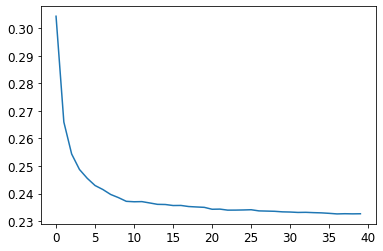

In [54]:
# We cab also vizualise the models performance as we increase the amount of trees

plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [55]:
# Looking back at the results of the training, we can see that our training accuracy is slightly
# better than our validation. This can be due to 2 main reasons:
    # 1. The model is overfitting
    # 2. The future time period that we are using for validation behaves a little differently 
    
# We can find out which of these reasons applies by using the 'Out-Of-Bag' error (OOB)
# For overfitting, we can use OOB on our training set, where the idea is chooses trees that have calculation
# of rows error, but that row itself was not used in training that tree.

# This is kind of like creating a validation set out of the training data, and since that error is still
# lower than our validation set error, we can exlude overfitting as a reason

r_mse(m.oob_prediction_, y)

0.210776

In [56]:
# Here are some important question that we can pose when trying to understand and improve our tabular model
# and we will go through how to answer them below

# How confident are we in our predictions using a particular row of data?
# For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
# Which columns are the strongest predictors, which can we ignore?
# Which columns are effectively redundant with each other, for purposes of prediction?
# How do predictions vary, as we vary these columns?

In [57]:
# [How confident are we in our predictions using a particular row of data?]

# One intersting insight would be the standard deviation that is see across each tree, which tells
# us the relative confidence of the models

preds_std = preds.std(0)

In [58]:
preds_std[:5]

array([0.26069358, 0.10409366, 0.09904178, 0.27184634, 0.13110276])

In [59]:
# [Which columns are the strongest predictors, which can we ignore?]

# Another powerful tool in our arsenal is the 'feature_importances_', which gives us valuable information
# as to how the model is making predictions

# How it works is pretty neat: It goes through each split in the models, and adds a weight based on 
# which column split improves the model

m.feature_importances_

array([5.57450493e-04, 3.16642223e-02, 2.08364585e-02, 4.61041998e-02, 3.81888207e-03, 2.02210664e-02, 1.17253496e-01, 7.31117255e-02, 4.73853730e-03, 2.37050535e-02, 1.47955429e-02, 7.94103747e-03,
       4.04953816e-02, 6.57471946e-04, 2.40087806e-04, 4.70580841e-04, 5.69211017e-04, 1.86769402e-03, 2.04792167e-04, 1.47385665e-03, 8.62045917e-04, 1.63400738e-03, 4.65562440e-04, 1.38626321e-02,
       3.01177774e-04, 2.04300035e-03, 9.32780622e-04, 3.27446943e-04, 5.23526083e-03, 2.34310027e-03, 1.17053139e-01, 4.11958892e-02, 3.27249950e-02, 1.80326162e-03, 9.45236127e-04, 9.56531910e-04,
       4.54328250e-04, 2.74944905e-04, 2.01497610e-04, 7.62913897e-04, 1.99777288e-03, 2.26417860e-03, 2.26780871e-04, 2.04400311e-04, 3.04663612e-05, 1.75051343e-05, 6.49242727e-06, 5.31301769e-06,
       0.00000000e+00, 0.00000000e+00, 1.23223591e-04, 6.45467310e-04, 2.49110272e-02, 1.48501980e-02, 5.47771720e-02, 8.80301114e-04, 2.68710872e-03, 1.73022725e-01, 1.59725158e-03, 2.13126465e-02,
     

In [60]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [61]:
fi = rf_feat_importance(m, xs)

In [62]:
fi[:10]

,cols,imp
57,YearMade,0.173023
6,ProductSize,0.117253
30,Coupler_System,0.117053
7,fiProductClassDesc,0.073112
54,ModelID,0.054777
65,saleElapsed,0.048835
3,fiSecondaryDesc,0.046104
31,Grouser_Tracks,0.041196
12,Enclosure,0.040495
32,Hydraulics_Flow,0.032725


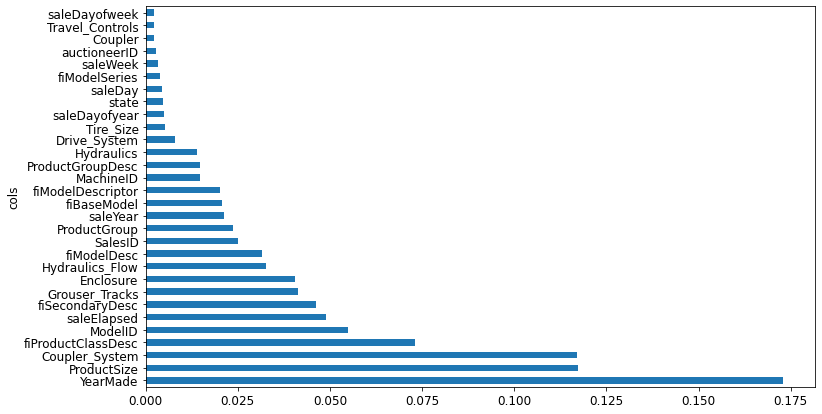

In [63]:
# Even nicer, we can plot them

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [64]:
# Lets try removing features that have a lower importance

to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

In [65]:
# We create new independent variables to train our new models

xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [66]:
m = rf(xs_imp, y)

In [67]:
# Lets see our new results

m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.18131, 0.230503)

In [68]:
# Although or accuracy has not cahnged from the last train, we have gon efrom 78 to 21 columns
# and that makes our lives easier in terms of havng to study each of the features and also makes life easier
# when rolling out and maintaining the model

len(xs.columns), len(xs_imp.columns)

(66, 21)

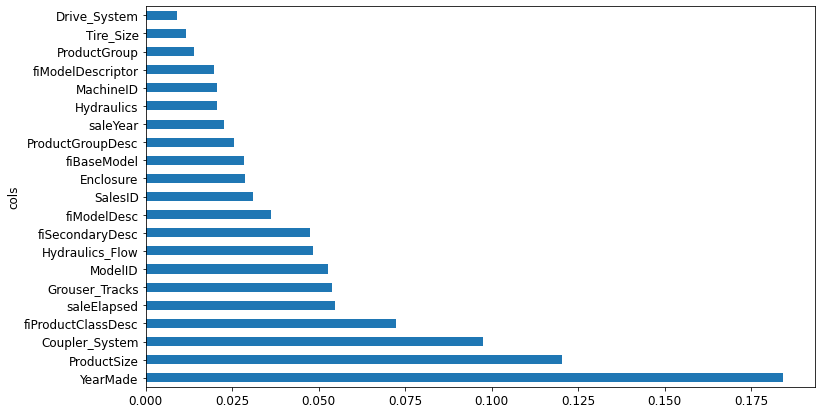

In [69]:
# We now have a narrowed list of the features, and can take take a better look at the data

plot_fi(rf_feat_importance(m, xs_imp));

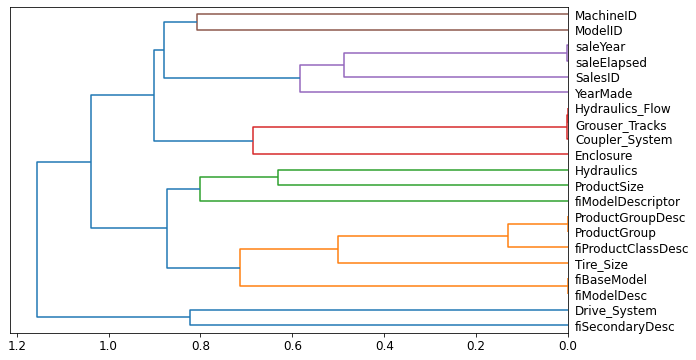

In [70]:
# [Which columns are effectively redundant with each other, for purposes of prediction?]

# We notice what seem to be duplicates such as ProductGroupDesc and ProductGroup. So lets take dive into what
# else could be redundant using fastai's 'cluster_columns' function

# The thicker colors on the far right indicate which columns are similar to each other

cluster_columns(xs_imp)

In [71]:
# To avoid retraining an intricate model to test these redundant features, we create a less intense model
# that also returns the OOB score, which is an r^2 values indicating the accuracy of the model

def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [72]:
get_oob(xs_imp)

0.8781576734893485

In [73]:
# We create a little loop to test dropping each of these features to give as some insight

{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8768628311464004,
 'saleElapsed': 0.8722097904682757,
 'ProductGroupDesc': 0.8770087512874477,
 'ProductGroup': 0.8778594920344923,
 'fiModelDesc': 0.8754781084425128,
 'fiBaseModel': 0.8761168180455399,
 'Hydraulics_Flow': 0.8774995916903535,
 'Grouser_Tracks': 0.8775565092698138,
 'Coupler_System': 0.8770165273393064}

In [74]:
# We choose some of the redundants and drop them all, and we see that we are not doing much worse despite that
# we have removed 4 features

to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8750482697068109

In [75]:
# We choose create new variable with the redundant features dropped

xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [76]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

In [77]:
# We can load the saved pkl files as seen before 

xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

In [78]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183251, 0.232259)

In [79]:
# [How do predidcitons vary as we vary these columns?]

# We now zoom in on our most important features: ProductSize and YearMade. We'd like to understand
# The relationship these values have with the Sale Price dependent variable

# We first take a look at the classes in the features using Pandas' 'value_counts' method

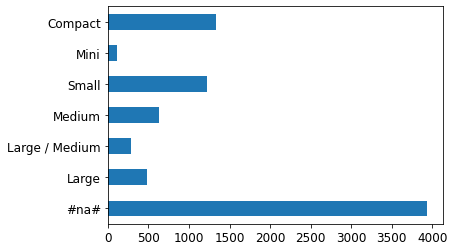

In [80]:
# Using a bar chart for ProductSize

p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

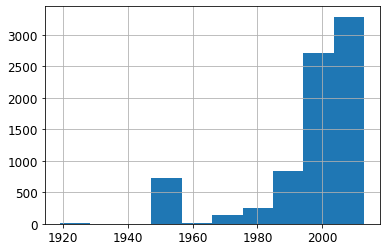

In [81]:
# We use a histogram for year made

ax = valid_xs_final['YearMade'].hist()

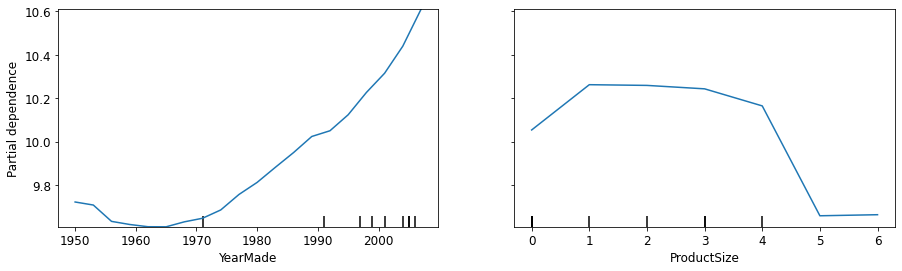

In [82]:
# Next we can do this neat trick called partial dependence plotting where we can see how the features alone
# affect the dependent variable sales price

# For our YearMade, we can easily make sense of the trend in the graph, where we would expect the sales price
# to go up a the years progress

# However, the ProductSize plot is a little concerning in that final group 'na' has the lowest price 
# while it also has the highest category amongst the other sizes, so it's would be important to see
# why 'na' is used so often and what significance it has in our predicitons

from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(15, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

In [83]:
# [For predicting with a particular row of data, what were the most important factors, 
# and how did they influence that prediction?]

# Earlier we were looking at the feature columns and assessing how these were affecting our auction predicitons

# This time we can follow the decision and split process for one single row (auction)
# We use our tree interpreter and waterfall chart to do this

#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [84]:
# Lets demonstrate this with the first few rows of our validation set

row = valid_xs_final.iloc[:5]

In [85]:
# Using the treeinterpreter.predict method we can get the prediction, bias, and contribution that each
# feature has to that specific row

prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [86]:
prediction[0], bias[0], contributions[0].sum()

(array([9.94708073]), 10.104746057831763, -0.15766532528651994)

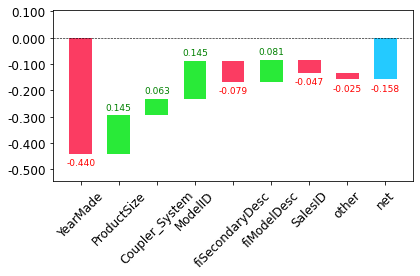

In [87]:
# We can lay this out nicely using the waterfall plot

waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

In [88]:
# Extrapolation problem
# A common issue in Data Science (and all mathematical models for that matter) is that the models 
# we build don't always generalize well to new data

# Lets take a look at how Random Forests extrapolate using 40 randomly generated points

In [89]:
#hide
np.random.seed(42)

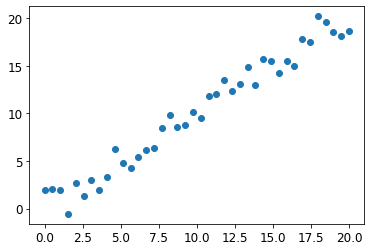

In [90]:
# WE create a linear relationship and add some noise to it

x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

In [91]:
# Sklearn expects at least 2 independent variable, so use the unsqueeze method to add a unit axis to 
# our tensor

xs_lin = x_lin.unsqueeze(1)
x_lin.shape,xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [92]:
# We new create a random forests model using the first 30 points

m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

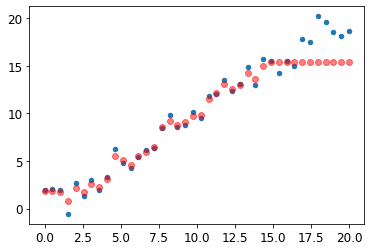

In [93]:
# Lets now test this model on the full data set, where our predictions are the orange points
# We see that the predictions hit a ceiling for the untrained variables

# The rationale for this behaviour is due to the behavior of Random Forests, which takes the average of 
# the predicitons of a number of trees, and the trees take the average value of the rows in a leaf.
# So trying make predictions on data that has not been trained, will hit a floor or roof as see here

# Examples of where this extrapolation can be a big factor is with time series data like the current
# Auction prediciton example, or Stock Market Predictions, or Inflation..

plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

In [94]:
# Based on the discovery above, we can try to omit the Out-Of-Domain Data that could lead to extrapolation
# That is, data that is not seen on our training set. For example, the date of sale is will contain values
# that our training data will have never seen, since we are valiating on data that takes place after our 
# training set

In [95]:
# One neat way of finding Out-Of-Domain data is to create a Random Forests model that can predict
# whether a row is in the validation or training set.

# We will then read into the feature inmportance to see what factors played the biggest part in 
# deciding which set the row belonged in. Those features tell us where the disparites lie.

# Unsurprisingly, the SalesElapsed was a large factor. SalesID was as well, which indicates there is 
# some sort of incrementation happening with these values. We also have other factors as listed below.

df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.858008
10,SalesID,0.098377
13,MachineID,0.035284
0,YearMade,0.002645
4,ModelID,0.001238
7,Enclosure,0.000891


In [96]:
# Lets experiment with removing each of these values and see if our validation accuracy increases

m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.231847
SalesID 0.231492
saleElapsed 0.235826
MachineID 0.231672


In [97]:
# Based on the results above we can exlude the Sales and Machine ID's and behold we see some 
# Improved reuslts. 
# Its important to note that doing this make our model more resilient in the long run since we 
# avoid the potential domain shift that would result from out-of-domain data


time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.228826

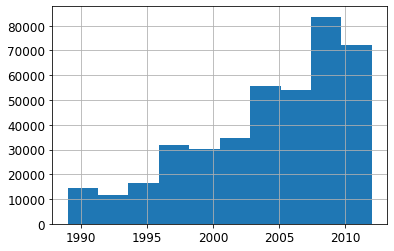

In [98]:
# One thing that could improve accuracy and prevent domain shift is the removal of old data

xs['saleYear'].hist();

In [99]:
# Lets exlude data from 2004 in our next model

filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [100]:
# Unlike the lecture, our accuracy has actually gone down, but in the long run, training on newer
# data could still be a better move for model resilience 

m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.177757, 0.229866)

In [101]:
# Lets now train a Neural Network using our approach from the last lecture:
# Here we will make good use of embedding, and buid on top of the embedded layers with dense layers.
# The expectation here is that our trained model will be much better at extrapolating predicitons
# Than our random forests

# NOTE: Random Forests are far from being in the rearview mirror. We will actually
# find that it is a great tool while creating our NN model.

In [102]:
# We will take the approach with setting up the independent and dependent variables as we had at the 
# beggining of this workbook

df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [103]:
# Lets also take advantage of using the fine tuned columns from the random forests

df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [104]:
# When working with Neural Networks, we should tell our neaural network which columns are categorical
# One way we can do this is to set the max_card parameter. Here we choose 9000, this means that anything under
# is going to be treated as a categorical variable by fastai.

# We use the same cont_cat_split fucntion given to us earlier

cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [105]:
# We should still be knowledgeable of our data, in our case we have the 'SaleElapsed' variable
# which we would want to treat as a continuous variable, so lets make sure that is continuous

cont_nn

['saleElapsed']

In [106]:
# Here we can see the unique catergories that exist for each column

df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Enclosure                6
Hydraulics_Flow          3
fiModelDesc           5059
ProductGroup             6
fiModelDescriptor      140
Hydraulics              12
Drive_System             4
Tire_Size               17
dtype: int64

In [107]:
# We usually want to be a little careful when dealign with high number categories, since we each of these 
# categories will hold a learnable parameter, that would be a lot of extra computing
# In the case of our current model, we see ModelID and fiModelDescriptor could be the same thing in essence

# We can use random forests to test how well our model performs without fiModelDescriptor
# We see that our model is only slightly worse, so we can live without that extra feature

xs_filt2 = xs_filt.drop('fiModelDesc', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDesc', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.180631, 0.233128)

In [108]:
cat_nn.remove('fiModelDesc')

In [109]:
# Lets make sure that it has been removed

df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Enclosure                6
Hydraulics_Flow          3
ProductGroup             6
fiModelDescriptor      140
Hydraulics              12
Drive_System             4
Tire_Size               17
dtype: int64

In [110]:
# We now create our TabularPandas object in a similar fashion as the random forests. Since we are working 
# with Neural nets, we want to normalize/standardize our data.. Mathematically, this means that we
# subtract the independent value by the mean and divide by the standard deviation.

# Normalizing is a very helpful when dealing with varieties of data that are different in range as it 
# scales the values of the data, and hence, prevents possible instabilities that may arise from
# large weights, known as the exploding gradient problem

# Learn more about normalization see the following link: https://www.youtube.com/watch?v=dXB-KQYkzNU

# To learn about vansihing and exploding gradients: https://www.youtube.com/watch?v=qO_NLVjD6zE

procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [111]:
# We now assign a batch size using the dataloaders, here we can use a larger size since this is not a 
# Convolutional Neurual Network

dls = to_nn.dataloaders(1024)

In [112]:
# We will also select the range as we normally should with regression models we can find the 
# range using the min and max methods found below

y = to_nn.train.y
y.min(),y.max()

(8.465899467468262, 11.863582611083984)

In [113]:
# We now leverage fastai's tabular_learner 

learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.00015848931798245758)

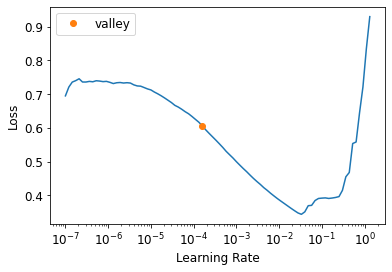

In [114]:
# We also use the previously used learning rate finder

learn.lr_find()

In [115]:
# We train the model over 5 epochs 

learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,time
0,0.059060,0.062038,00:04
1,0.051455,0.053610,00:04
2,0.046835,0.051628,00:04
3,0.042512,0.050819,00:04
4,0.039400,0.050247,00:04


In [116]:
# We use our r_mse function to see how our tabular nn compares with the random forests, in our case
# its actually done a little bit better than oiur random forests 

preds,targs = learn.get_preds()
r_mse(preds,targs)

0.224158

In [117]:
# We save our model

learn.save('nn')

Path('models/nn.pth')

In [123]:
# A tabular model is simply a model that takes columns of continuous or categorical data, and predicts 
# a category (a classification model) or a continuous value (a regression model). 
# Categorical independent variables are passed through an embedding, and concatenated, 
# as we saw in the neural net we used for collaborative filtering, and then continuous variables are 
# concatenated as well.

tabular_learner??

In [121]:
from fastai.collab import *

In [122]:
# like collab_learner, tabular_learner first calls get_emb_sz to calculate appropriate embedding sizes 
# (you can override these by using the emb_szs parameter, which is a dictionary containing 
#  any column names you want to set sizes for manually), and it sets a few other defaults

collab_learner??

In [124]:
# Ensembles
# An powerful yet simple strategy is combining the results of multiple models together through averaging
# Much like the random forests, we are leveraging the fact that each model has its own unique errors as a 
# good reason to pull those models together, and we see below that doing so is quite effective

In [125]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [126]:
r_mse(ens_preds,valid_y)

0.222154

In [ ]:
# BOOSTING
#     1. Train a small model that underfits your dataset.
#     2. Calculate the predictions in the training set for this model.
#     3. Subtract the predictions from the targets; these are called the "residuals" and represent the 
#        error for each point in the training set.
#     4. Go back to step 1, but instead of using the original targets, use the residuals as the 
#        targets for the training.
#     5. Continue doing this until you reach some stopping criterion, such as a maximum number 
#        of trees, or you observe your validation set error getting worse.

In [118]:
# SIDEBAR on popular methods per my personal research:
# The strategy of boosting is by far the most effective when it comes to tabular modeling, with XDGBoost
# taking the the throne at the current time

# Here is a good blog post that goes into details on the various popular methods and how they compare 
# There is also a link the repository that has some useful source code when it becomes time to pick up
# XDGBoost: https://www.martinalarcon.org/2018-12-31-b-water-pumps/